In [10]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib import learn
from sklearn import preprocessing
from sklearn import metrics
from __future__ import print_function
import itertools
#from tensorflow.python.ops import math_ops

%matplotlib inline

In [11]:
#%run ./importWalkingDataConfidence_strongerWts.ipynb
%run ./importWalkingDataConfidence.ipynb
tf.logging.set_verbosity(tf.logging.INFO)

Dimension of walking test_x  =  (134, 27)
Dimension of walking train_x =  (536, 27)


./dataFix.ipynb:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  {
./dataFix.ipynb:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  {


In [12]:
def get_input_fn(data_x,data_y, LABEL, num_epochs=None, shuffle=True):
  return tf.estimator.inputs.pandas_input_fn(
      x=pd.DataFrame({k: data_x[k].values for k in FEATURESALL_WTS}),
      y = pd.DataFrame(data_y[LABEL].values),
      num_epochs=num_epochs,
      shuffle=shuffle)

In [13]:
embedded_ffp_column = tf.contrib.layers.embedding_column(
    tf.contrib.layers.sparse_column_with_integerized_feature("FFPType", 7, combiner=None, dtype=tf.int64), dimension = 7)
sparse_ffp_column =  tf.contrib.layers.sparse_column_with_integerized_feature("FFPType", 7, combiner=None, dtype=tf.int64)
# Continuous columns- frontKneesAngle	rearKneesAngle	frontAnkle	rearAnkle	frontHipsAngle
bodyZ = tf.feature_column.numeric_column("bodyAngleZ")
frontK = tf.feature_column.numeric_column("frontKneesAngle")
rearK = tf.feature_column.numeric_column("rearKneesAngle")
frontA = tf.feature_column.numeric_column("frontAnkle")
rearA = tf.feature_column.numeric_column("rearAnkle")
frontH = tf.feature_column.numeric_column("frontHipsAngle")
rearH = tf.feature_column.numeric_column("rearHipsAngle")
swingFtHt = tf.feature_column.numeric_column("swingFtHeight")
speed = tf.feature_column.numeric_column("speed")
gaitTime = tf.feature_column.numeric_column("gaitDuration")

feature_cols = [bodyZ, frontK, rearK, frontA, rearA, frontH, rearH, swingFtHt, speed, gaitTime, embedded_ffp_column]
#lin_feature_cols = [bodyZ, frontK, rearK, frontA, rearA, frontH, rearH, swingFtHt, speed, gaitTime]
#lin_feature_cols = [sparse_ffp_column]
#lin_feature_cols = [bodyZ, swingFtHt, speed, gaitTime, sparse_ffp_column]
lin_feature_cols = [bodyZ, swingFtHt, speed, gaitTime]
#lin_feature_cols = [bodyZ, frontK, rearK, frontA, rearA, frontH, rearH, swingFtHt, speed, gaitTime, sparse_ffp_column]

In [14]:
LABEL_ID = 1;
LABEL = EMOSCORES[LABEL_ID]
WT_COL = WTS_LABEL[LABEL_ID]

In [6]:
WT_COL

'sadder_wt'

In [7]:
# validation_metrics = {
#     "rmse":
#         tf.metrics.root_mean_squared_error(labels = pd.DataFrame(y_test[LABEL].values),predictions=y_predicted)
# }

In [15]:
validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
input_fn=get_input_fn(X_test_all_wts, y_test, LABEL, num_epochs=1, shuffle=False),
    every_n_steps=50,
    early_stopping_metric="loss",
    early_stopping_metric_minimize=True,
    early_stopping_rounds=500) #200 500 1000
    #metrics=validation_metrics)

Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.


In [18]:
# Build a wide + deep model
#model_dir_name="/DNN/wideAndDeep/wideMotionBodyAngDeepAllStrngWts_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001"
model_dir_name="/DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceELU2Layer1000_1000UnitsDropout04EarlyStopLR001"

# regressor = tf.contrib.learn.DNNLinearCombinedRegressor(linear_feature_columns = lin_feature_cols,
#   dnn_feature_columns=feature_cols, dnn_hidden_units=[1000],  model_dir=model_dir_name, weight_column_name = WT_COL,
#     dnn_optimizer = tf.train.AdamOptimizer(
#       learning_rate=0.01), dnn_dropout =0.1, config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1), dnn_activation_fn = tf.nn.softplus)

regressor = tf.contrib.learn.DNNLinearCombinedRegressor(linear_feature_columns = lin_feature_cols,
  dnn_feature_columns=feature_cols, dnn_hidden_units=[1000,1000],  model_dir=model_dir_name, weight_column_name = WT_COL,
    dnn_optimizer = tf.train.AdamOptimizer(
      learning_rate=0.001), dnn_dropout =0.4, config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1), dnn_activation_fn = tf.nn.elu)

#tf.contrib.layers.xavier_initializer(uniform=True) # this seems more useful for vision stuff where there is lot of fan_in and fan_out

Instructions for updating:
Please set fix_global_step_increment_bug=True and update training steps in your pipeline. See pydoc for details.
INFO:tensorflow:Using config: {'_master': '', '_task_id': 0, '_keep_checkpoint_max': 5, '_save_checkpoints_steps': None, '_model_dir': '/DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceELU2Layer1000_1000UnitsDropout04EarlyStopLR001', '_save_summary_steps': 100, '_num_ps_replicas': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000000000CAE2C88>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_environment': 'local', '_keep_checkpoint_every_n_hours': 10000, '_is_chief': True, '_log_step_count_steps': 100, '_evaluation_master': '', '_save_checkpoints_secs': 1, '_tf_random_seed': None, '_task_type': None, '_session_config': None, '_num_worker_replicas': 0}


In [10]:
# Train.
regressor.fit(input_fn=get_input_fn(X_train_all_wts, y_train, LABEL, num_epochs=None, shuffle=True),steps=200000, monitors=[validation_monitor]) #2000000

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 2 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:step = 2, loss = 364.896
INFO:tensorflow:Saving checkpoints for 4 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 6 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 8 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 10 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 12 into /DNNNew/DNNSad/wideAnd

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-52
INFO:tensorflow:Finished evaluation at 2017-10-10-23:02:04
INFO:tensorflow:Saving dict for global step 52: global_step = 52, loss = 616.279
INFO:tensorflow:Validation (step 51): global_step = 52, loss = 616.279
INFO:tensorflow:Saving checkpoints for 54 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 56 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 58 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 60 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSo

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-102
INFO:tensorflow:Finished evaluation at 2017-10-10-23:02:36
INFO:tensorflow:Saving dict for global step 102: global_step = 102, loss = 535.126
INFO:tensorflow:Validation (step 101): global_step = 102, loss = 535.126
INFO:tensorflow:Saving checkpoints for 104 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 106 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 108 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 110 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_Con

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-152
INFO:tensorflow:Finished evaluation at 2017-10-10-23:03:06
INFO:tensorflow:Saving dict for global step 152: global_step = 152, loss = 469.303
INFO:tensorflow:Validation (step 151): global_step = 152, loss = 469.303
INFO:tensorflow:Saving checkpoints for 154 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 156 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 158 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 160 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_Con

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-202
INFO:tensorflow:Finished evaluation at 2017-10-10-23:03:35
INFO:tensorflow:Saving dict for global step 202: global_step = 202, loss = 409.008
INFO:tensorflow:Validation (step 201): global_step = 202, loss = 409.008
INFO:tensorflow:step = 202, loss = 208.462 (121.184 sec)
INFO:tensorflow:Saving checkpoints for 204 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 206 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 208 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 210 into

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-252
INFO:tensorflow:Finished evaluation at 2017-10-10-23:04:05
INFO:tensorflow:Saving dict for global step 252: global_step = 252, loss = 348.768
INFO:tensorflow:Validation (step 251): global_step = 252, loss = 348.768
INFO:tensorflow:Saving checkpoints for 254 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 256 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 258 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 260 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_Con

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-302
INFO:tensorflow:Finished evaluation at 2017-10-10-23:04:35
INFO:tensorflow:Saving dict for global step 302: global_step = 302, loss = 286.56
INFO:tensorflow:Validation (step 301): global_step = 302, loss = 286.56
INFO:tensorflow:Saving checkpoints for 304 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 306 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 308 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 310 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_Confi

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-352
INFO:tensorflow:Finished evaluation at 2017-10-10-23:05:05
INFO:tensorflow:Saving dict for global step 352: global_step = 352, loss = 222.657
INFO:tensorflow:Validation (step 351): global_step = 352, loss = 222.657
INFO:tensorflow:Saving checkpoints for 354 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 356 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 358 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 360 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_Con

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-402
INFO:tensorflow:Finished evaluation at 2017-10-10-23:05:35
INFO:tensorflow:Saving dict for global step 402: global_step = 402, loss = 158.653
INFO:tensorflow:Validation (step 401): global_step = 402, loss = 158.653
INFO:tensorflow:step = 402, loss = 86.4632 (119.343 sec)
INFO:tensorflow:Saving checkpoints for 404 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 406 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 408 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 410 into

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-452
INFO:tensorflow:Finished evaluation at 2017-10-10-23:06:05
INFO:tensorflow:Saving dict for global step 452: global_step = 452, loss = 101.847
INFO:tensorflow:Validation (step 451): global_step = 452, loss = 101.847
INFO:tensorflow:Saving checkpoints for 454 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 456 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 458 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 460 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_Con

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-502
INFO:tensorflow:Finished evaluation at 2017-10-10-23:06:34
INFO:tensorflow:Saving dict for global step 502: global_step = 502, loss = 60.2667
INFO:tensorflow:Validation (step 501): global_step = 502, loss = 60.2667
INFO:tensorflow:Saving checkpoints for 504 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 506 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 508 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 510 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_Con

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-552
INFO:tensorflow:Finished evaluation at 2017-10-10-23:07:04
INFO:tensorflow:Saving dict for global step 552: global_step = 552, loss = 38.0451
INFO:tensorflow:Validation (step 551): global_step = 552, loss = 38.0451
INFO:tensorflow:Saving checkpoints for 554 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 556 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 558 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 560 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_Con

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-602
INFO:tensorflow:Finished evaluation at 2017-10-10-23:07:34
INFO:tensorflow:Saving dict for global step 602: global_step = 602, loss = 28.9818
INFO:tensorflow:Validation (step 601): global_step = 602, loss = 28.9818
INFO:tensorflow:step = 602, loss = 26.3679 (119.161 sec)
INFO:tensorflow:Saving checkpoints for 604 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 606 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 608 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 610 into

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-652
INFO:tensorflow:Finished evaluation at 2017-10-10-23:08:04
INFO:tensorflow:Saving dict for global step 652: global_step = 652, loss = 25.1786
INFO:tensorflow:Validation (step 651): global_step = 652, loss = 25.1786
INFO:tensorflow:Saving checkpoints for 654 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 656 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 658 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 660 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_Con

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-702
INFO:tensorflow:Finished evaluation at 2017-10-10-23:08:33
INFO:tensorflow:Saving dict for global step 702: global_step = 702, loss = 23.436
INFO:tensorflow:Validation (step 701): global_step = 702, loss = 23.436
INFO:tensorflow:Saving checkpoints for 704 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 706 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 708 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 710 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_Confi

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-752
INFO:tensorflow:Finished evaluation at 2017-10-10-23:09:03
INFO:tensorflow:Saving dict for global step 752: global_step = 752, loss = 21.8368
INFO:tensorflow:Validation (step 751): global_step = 752, loss = 21.8368
INFO:tensorflow:Saving checkpoints for 754 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 756 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 758 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 760 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_Con

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-802
INFO:tensorflow:Finished evaluation at 2017-10-10-23:09:33
INFO:tensorflow:Saving dict for global step 802: global_step = 802, loss = 20.8471
INFO:tensorflow:Validation (step 801): global_step = 802, loss = 20.8471
INFO:tensorflow:step = 802, loss = 23.4041 (119.461 sec)
INFO:tensorflow:Saving checkpoints for 804 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 806 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 808 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 810 into

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-852
INFO:tensorflow:Finished evaluation at 2017-10-10-23:10:03
INFO:tensorflow:Saving dict for global step 852: global_step = 852, loss = 20.148
INFO:tensorflow:Validation (step 851): global_step = 852, loss = 20.148
INFO:tensorflow:Saving checkpoints for 854 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 856 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 858 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 860 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_Confi

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-902
INFO:tensorflow:Finished evaluation at 2017-10-10-23:10:33
INFO:tensorflow:Saving dict for global step 902: global_step = 902, loss = 19.5516
INFO:tensorflow:Validation (step 901): global_step = 902, loss = 19.5516
INFO:tensorflow:Saving checkpoints for 904 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 906 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 908 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 910 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_Con

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-952
INFO:tensorflow:Finished evaluation at 2017-10-10-23:11:03
INFO:tensorflow:Saving dict for global step 952: global_step = 952, loss = 19.3654
INFO:tensorflow:Validation (step 951): global_step = 952, loss = 19.3654
INFO:tensorflow:Saving checkpoints for 954 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 956 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 958 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 960 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_Con

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-1002
INFO:tensorflow:Finished evaluation at 2017-10-10-23:11:32
INFO:tensorflow:Saving dict for global step 1002: global_step = 1002, loss = 19.0325
INFO:tensorflow:Validation (step 1001): global_step = 1002, loss = 19.0325
INFO:tensorflow:step = 1002, loss = 14.6499 (119.077 sec)
INFO:tensorflow:Saving checkpoints for 1004 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1006 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1008 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-1052
INFO:tensorflow:Finished evaluation at 2017-10-10-23:12:02
INFO:tensorflow:Saving dict for global step 1052: global_step = 1052, loss = 19.0708
INFO:tensorflow:Validation (step 1051): global_step = 1052, loss = 19.0708
INFO:tensorflow:Saving checkpoints for 1054 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1056 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1058 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1060 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAn

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-1102
INFO:tensorflow:Finished evaluation at 2017-10-10-23:12:32
INFO:tensorflow:Saving dict for global step 1102: global_step = 1102, loss = 18.7494
INFO:tensorflow:Validation (step 1101): global_step = 1102, loss = 18.7494
INFO:tensorflow:Saving checkpoints for 1104 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1106 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1108 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1110 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAn

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-1152
INFO:tensorflow:Finished evaluation at 2017-10-10-23:13:02
INFO:tensorflow:Saving dict for global step 1152: global_step = 1152, loss = 18.6939
INFO:tensorflow:Validation (step 1151): global_step = 1152, loss = 18.6939
INFO:tensorflow:Saving checkpoints for 1154 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1156 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1158 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1160 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAn

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-1202
INFO:tensorflow:Finished evaluation at 2017-10-10-23:13:32
INFO:tensorflow:Saving dict for global step 1202: global_step = 1202, loss = 18.5753
INFO:tensorflow:Validation (step 1201): global_step = 1202, loss = 18.5753
INFO:tensorflow:step = 1202, loss = 19.6587 (119.060 sec)
INFO:tensorflow:Saving checkpoints for 1204 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1206 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1208 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-1252
INFO:tensorflow:Finished evaluation at 2017-10-10-23:14:01
INFO:tensorflow:Saving dict for global step 1252: global_step = 1252, loss = 18.8589
INFO:tensorflow:Validation (step 1251): global_step = 1252, loss = 18.8589
INFO:tensorflow:Saving checkpoints for 1254 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1256 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1258 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1260 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAn

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-1302
INFO:tensorflow:Finished evaluation at 2017-10-10-23:14:31
INFO:tensorflow:Saving dict for global step 1302: global_step = 1302, loss = 18.6686
INFO:tensorflow:Validation (step 1301): global_step = 1302, loss = 18.6686
INFO:tensorflow:Saving checkpoints for 1304 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1306 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1308 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1310 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAn

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-1352
INFO:tensorflow:Finished evaluation at 2017-10-10-23:15:01
INFO:tensorflow:Saving dict for global step 1352: global_step = 1352, loss = 18.344
INFO:tensorflow:Validation (step 1351): global_step = 1352, loss = 18.344
INFO:tensorflow:Saving checkpoints for 1354 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1356 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1358 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1360 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngD

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-1402
INFO:tensorflow:Finished evaluation at 2017-10-10-23:15:31
INFO:tensorflow:Saving dict for global step 1402: global_step = 1402, loss = 18.0754
INFO:tensorflow:Validation (step 1401): global_step = 1402, loss = 18.0754
INFO:tensorflow:step = 1402, loss = 20.8947 (119.978 sec)
INFO:tensorflow:Saving checkpoints for 1404 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1406 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1408 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-1452
INFO:tensorflow:Finished evaluation at 2017-10-10-23:16:01
INFO:tensorflow:Saving dict for global step 1452: global_step = 1452, loss = 18.5359
INFO:tensorflow:Validation (step 1451): global_step = 1452, loss = 18.5359
INFO:tensorflow:Saving checkpoints for 1454 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1456 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1458 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1460 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAn

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-1502
INFO:tensorflow:Finished evaluation at 2017-10-10-23:16:31
INFO:tensorflow:Saving dict for global step 1502: global_step = 1502, loss = 18.4563
INFO:tensorflow:Validation (step 1501): global_step = 1502, loss = 18.4563
INFO:tensorflow:Saving checkpoints for 1504 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1506 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1508 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1510 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAn

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-1552
INFO:tensorflow:Finished evaluation at 2017-10-10-23:17:01
INFO:tensorflow:Saving dict for global step 1552: global_step = 1552, loss = 18.377
INFO:tensorflow:Validation (step 1551): global_step = 1552, loss = 18.377
INFO:tensorflow:Saving checkpoints for 1554 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1556 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1558 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1560 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngD

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-1602
INFO:tensorflow:Finished evaluation at 2017-10-10-23:17:31
INFO:tensorflow:Saving dict for global step 1602: global_step = 1602, loss = 18.3254
INFO:tensorflow:Validation (step 1601): global_step = 1602, loss = 18.3254
INFO:tensorflow:step = 1602, loss = 21.9974 (119.048 sec)
INFO:tensorflow:Saving checkpoints for 1604 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1606 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1608 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-1652
INFO:tensorflow:Finished evaluation at 2017-10-10-23:18:00
INFO:tensorflow:Saving dict for global step 1652: global_step = 1652, loss = 18.3569
INFO:tensorflow:Validation (step 1651): global_step = 1652, loss = 18.3569
INFO:tensorflow:Saving checkpoints for 1654 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1656 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1658 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1660 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAn

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-1702
INFO:tensorflow:Finished evaluation at 2017-10-10-23:18:30
INFO:tensorflow:Saving dict for global step 1702: global_step = 1702, loss = 18.3751
INFO:tensorflow:Validation (step 1701): global_step = 1702, loss = 18.3751
INFO:tensorflow:Saving checkpoints for 1704 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1706 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1708 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1710 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAn

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-1752
INFO:tensorflow:Finished evaluation at 2017-10-10-23:19:00
INFO:tensorflow:Saving dict for global step 1752: global_step = 1752, loss = 18.2797
INFO:tensorflow:Validation (step 1751): global_step = 1752, loss = 18.2797
INFO:tensorflow:Saving checkpoints for 1754 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1756 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1758 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1760 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAn

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-1802
INFO:tensorflow:Finished evaluation at 2017-10-10-23:19:30
INFO:tensorflow:Saving dict for global step 1802: global_step = 1802, loss = 18.2045
INFO:tensorflow:Validation (step 1801): global_step = 1802, loss = 18.2045
INFO:tensorflow:step = 1802, loss = 17.8189 (119.255 sec)
INFO:tensorflow:Saving checkpoints for 1804 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1806 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1808 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-1852
INFO:tensorflow:Finished evaluation at 2017-10-10-23:20:00
INFO:tensorflow:Saving dict for global step 1852: global_step = 1852, loss = 18.3901
INFO:tensorflow:Validation (step 1851): global_step = 1852, loss = 18.3901
INFO:tensorflow:Saving checkpoints for 1854 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1856 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1858 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1860 into /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAn

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-1902
INFO:tensorflow:Finished evaluation at 2017-10-10-23:20:29
INFO:tensorflow:Saving dict for global step 1902: global_step = 1902, loss = 18.226
INFO:tensorflow:Validation (step 1901): global_step = 1902, loss = 18.226
INFO:tensorflow:Stopping. Best step: 1401 with loss = 18.07541847229004.
INFO:tensorflow:Loss for final step: 18.7749.


DNNLinearCombinedRegressor(params={'dnn_feature_columns': [_NumericColumn(key='bodyAngleZ', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='frontKneesAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='rearKneesAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='frontAnkle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='rearAnkle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='frontHipsAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='rearHipsAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='swingFtHeight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='speed', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn

In [19]:
 ev = regressor.evaluate(
     input_fn=get_input_fn(X_test_all_wts, y_test, LABEL, num_epochs=1, shuffle=False))#,metrics=validation_metrics)
print('MSE (tensorflow): {0:f}'.format(ev['loss']))

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2017-11-13-20:05:48


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceELU2Layer1000_1000UnitsDropout04EarlyStopLR001\model.ckpt-900
INFO:tensorflow:Finished evaluation at 2017-11-13-20:05:48
INFO:tensorflow:Saving dict for global step 900: global_step = 900, loss = 17.1952
MSE (tensorflow): 17.195211


In [20]:
predictions = regressor.predict_scores(input_fn=get_input_fn(X_test_all_wts, y_test, LABEL, num_epochs=1, shuffle=False))
y_predicted = list(itertools.islice(predictions,y_test[LABEL].size))

INFO:tensorflow:Restoring parameters from /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceELU2Layer1000_1000UnitsDropout04EarlyStopLR001\model.ckpt-900


In [13]:
y_predicted

[23.9063,
 31.372902,
 23.067478,
 24.87241,
 19.8508,
 19.027534,
 32.67057,
 32.319328,
 17.559387,
 18.02784,
 28.116325,
 32.036343,
 27.424644,
 28.402658,
 28.469803,
 24.040401,
 25.206356,
 23.055553,
 27.107674,
 18.527323,
 29.335295,
 27.21287,
 27.248459,
 19.012415,
 23.394669,
 29.193769,
 22.990335,
 25.844427,
 32.624249,
 18.687267,
 30.758654,
 27.613079,
 23.43535,
 19.961388,
 21.29825,
 25.584784,
 25.740398,
 20.413774,
 18.213596,
 25.908291,
 18.543867,
 25.344913,
 33.076096,
 25.202965,
 22.447248,
 20.02676,
 24.21245,
 17.965048,
 30.640169,
 22.776146,
 27.107904,
 20.055191,
 19.78347,
 24.351494,
 27.863846,
 29.01474,
 30.092247,
 24.098701,
 24.117052,
 29.707554,
 24.726614,
 26.616337,
 28.892315,
 23.128387,
 25.105694,
 19.0812,
 22.558699,
 29.60998,
 22.640617,
 21.836487,
 27.197971,
 18.648293,
 19.070477,
 19.21562,
 22.744247,
 25.341181,
 25.352692,
 24.738075,
 20.21002,
 24.479948,
 23.047356,
 26.791489,
 22.898081,
 20.217228,
 31.88184,


In [21]:
# Score with sklearn.
score_sklearn = metrics.mean_squared_error(y_test[LABEL].values,y_predicted)
print('MSE (sklearn): {0:f}'.format(score_sklearn))
r2_score = metrics.r2_score(y_test[LABEL].values, y_predicted)
print('R2 (sklearn): {0:f}'.format(r2_score))
# Score with sklearn.
score_sklearn_wtd = metrics.mean_squared_error(y_test[LABEL].values,y_predicted,sample_weight=X_test_all_wts[WT_COL].values)
print('MSE WTD (sklearn): {0:f}'.format(score_sklearn_wtd))
r2_score_wtd = metrics.r2_score(y_test[LABEL].values, y_predicted, sample_weight=X_test_all_wts[WT_COL].values)
print('R2 WTD (sklearn): {0:f}'.format(r2_score_wtd))

MSE (sklearn): 28.897261
R2 (sklearn): 0.320378
MSE WTD (sklearn): 26.831827
R2 WTD (sklearn): 0.365818


In [22]:
predicted_name ="predicted_"+LABEL

In [23]:
predicted_name ="predicted_"+LABEL
y_hat = pd.DataFrame(y_predicted, columns=[predicted_name], index=y_test[LABEL].index) 

In [24]:
y_all = pd.concat([y_hat, y_test[LABEL], y_test[EMOCONFIDENCE_INV[LABEL_ID]], y_test["gif_id"]], axis=1) #gif id is only for debuggingK

In [25]:
y_all_sorted = y_all.sort_values(EMOSCORES[LABEL_ID],ascending=[True])

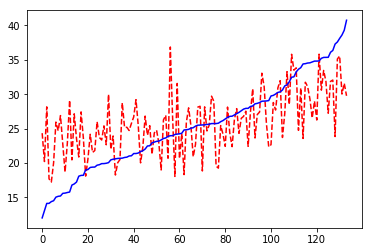

In [26]:
plt.figure()
plt.plot(y_all_sorted[predicted_name].values,'r--',y_all_sorted[LABEL].values,'b')

In [20]:
regressor.get_params()

{'params': {'dnn_activation_fn': <function tensorflow.python.ops.gen_nn_ops.softplus>,
  'dnn_dropout': 0.1,
  'dnn_feature_columns': [_NumericColumn(key='bodyAngleZ', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='frontKneesAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='rearKneesAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='frontAnkle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='rearAnkle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='frontHipsAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='rearHipsAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='swingFtHeight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=N

In [21]:
ev_train = regressor.evaluate(
     input_fn=get_input_fn(X_train_all_wts, y_train, LABEL, num_epochs=1, shuffle=False))#,metrics=validation_metrics)
print('MSE train (tensorflow): {0:f}'.format(ev_train['loss']))
train_predictions = regressor.predict_scores(input_fn=get_input_fn(X_train_all_wts, y_train, LABEL, num_epochs=1, shuffle=False))
y_predicted_train = list(itertools.islice(train_predictions,y_train[LABEL].size))

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2017-10-10-23:20:34


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-1902
INFO:tensorflow:Finished evaluation at 2017-10-10-23:20:34
INFO:tensorflow:Saving dict for global step 1902: global_step = 1902, loss = 23.0668
MSE train (tensorflow): 23.066830
INFO:tensorflow:Restoring parameters from /DNNNew/DNNSad/wideAndDeep/sad_wideMotionBodyAngDeep_ConfidenceSoftPlus2Layer10_10UnitsDropout01EarlyStopLR001\model.ckpt-1902


In [22]:
# Score with sklearn.
score_sklearn_train = metrics.mean_squared_error(y_train[LABEL].values,y_predicted_train)
print('MSE train (sklearn): {0:f}'.format(score_sklearn_train))
r2_score_train = metrics.r2_score(y_train[LABEL].values, y_predicted_train)
print('R2 train (sklearn): {0:f}'.format(r2_score_train))
# Score with sklearn.
score_sklearn_wtd_train = metrics.mean_squared_error(y_train[LABEL].values,y_predicted_train,sample_weight=X_train_all_wts[WT_COL].values)
print('MSE WTD train (sklearn): {0:f}'.format(score_sklearn_wtd_train))
r2_score_wtd_train = metrics.r2_score(y_train[LABEL].values, y_predicted_train, sample_weight=X_train_all_wts[WT_COL].values)
print('R2 WTD train (sklearn): {0:f}'.format(r2_score_wtd_train))

MSE train (sklearn): 21.070813
R2 train (sklearn): 0.456168
MSE WTD train (sklearn): 20.618145
R2 WTD train (sklearn): 0.485374


Populating the interactive namespace from numpy and matplotlib


C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


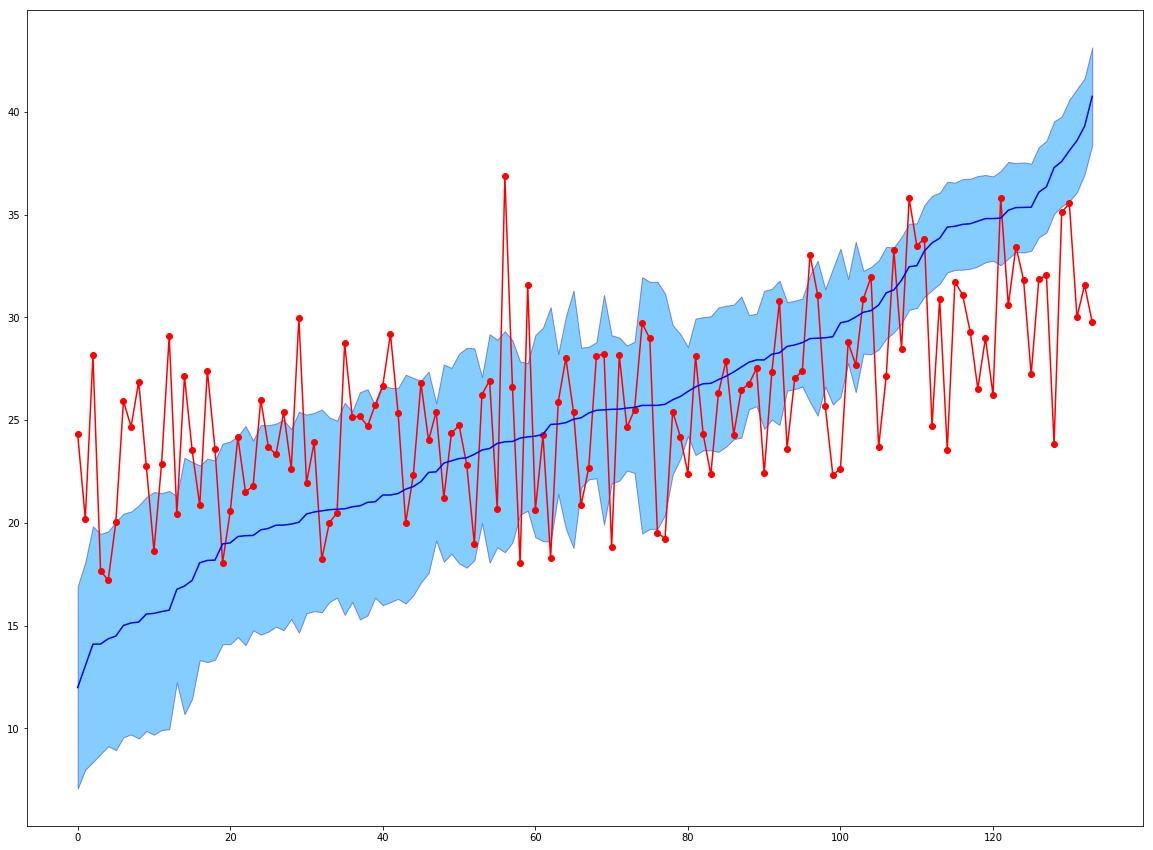

In [27]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_sorted[predicted_name].size, 1)
#plt.errorbar(x,y_all_sorted[predicted_name].values,yerr=0,fmt='r-o',label="predicted")
#plt.errorbar(x,y_all_sorted[LABEL].values,yerr=y_all_sorted[EMOCONFIDENCE_INV[LABEL_ID]],fmt='b',label="groundtruth")
plt.errorbar(x,y_all_sorted[predicted_name].values,fmt='r-o',label="predicted")
plt.fill_between(x, y_all_sorted[LABEL].values-y_all_sorted[EMOCONFIDENCE_INV[LABEL_ID]], y_all_sorted[LABEL].values+y_all_sorted[EMOCONFIDENCE_INV[LABEL_ID]],
    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.errorbar(x,y_all_sorted[LABEL].values,fmt='b',label="groundtruth")
#plt.title(model_dir_name,fontsize=18)
#plt.xlabel('test samples (#'+str(y_test[LABEL].size)+')',fontsize=18)
#plt.ylabel(LABEL +' scores',fontsize=18)
#plt.ylabel('sad predicted scores',fontsize=18)
# pylab.legend(loc='upper left', fontsize=18)
# plt.text(70,12, 'sklearn wtd r2 score='+str(r2_score_wtd), fontsize=18)
# plt.text(70,10, 'sklearn r2 score='+str(r2_score), fontsize=18)
# plt.text(70,8, 'sklearn wtd mse='+str(score_sklearn_wtd), fontsize=18)
# plt.text(70,6, 'sklearn mse='+str(score_sklearn), fontsize=18)
plt.show()
fig_name = model_dir_name + "/testPredictionSadShaded.pdf"
ax.savefig(fig_name) 

In [24]:
predicted_name_train ="predicted_"+LABEL+"_train"
y_hat_train = pd.DataFrame(y_predicted_train, columns=[predicted_name_train], index=y_train[LABEL].index) 
y_all_train = pd.concat([y_hat_train, y_train[LABEL], y_train[EMOCONFIDENCE_INV[LABEL_ID]], y_train["gif_id"]], axis=1) #gif id is only for debugging
y_all_sorted_train = y_all_train.sort_values(EMOSCORES[LABEL_ID],ascending=[True])

Populating the interactive namespace from numpy and matplotlib


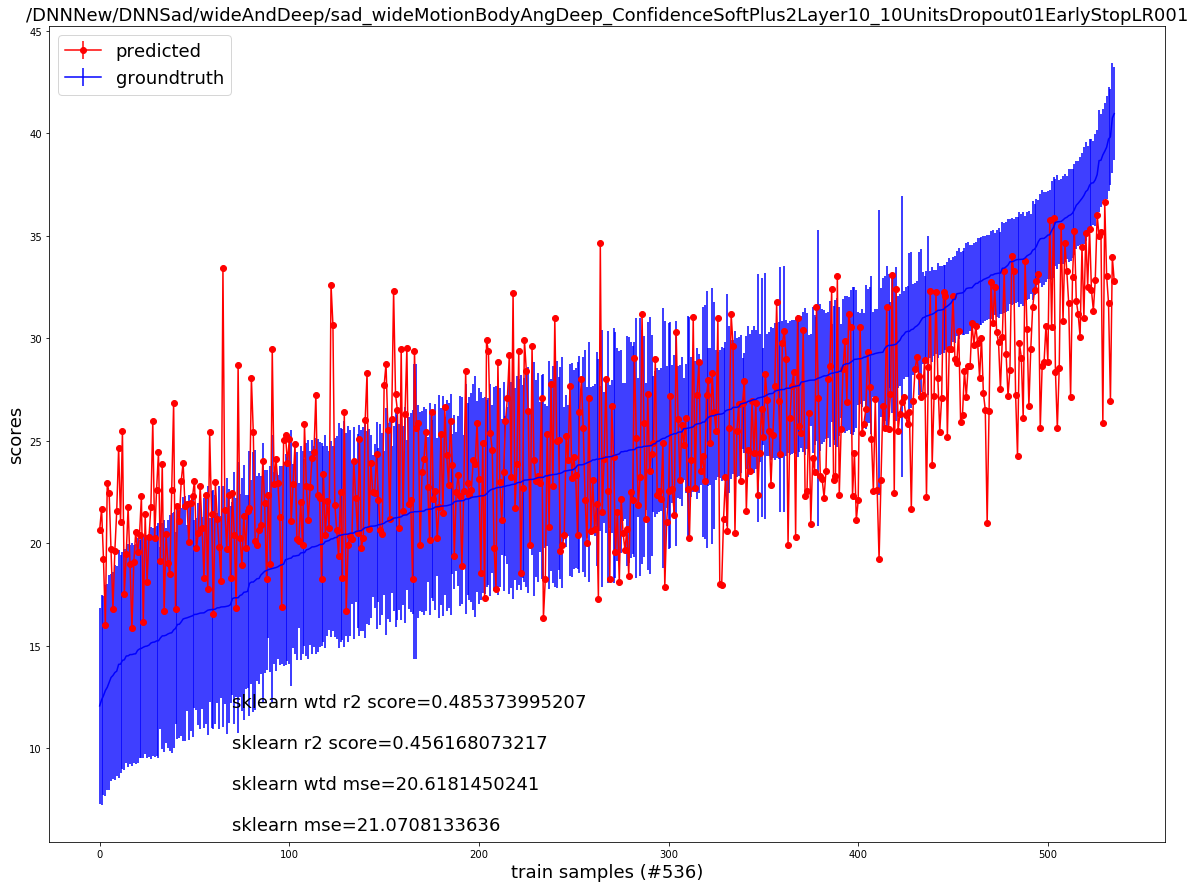

In [25]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_sorted_train[predicted_name_train].size, 1)
plt.errorbar(x,y_all_sorted_train[predicted_name_train].values,yerr=0,fmt='r-o',label="predicted")
plt.errorbar(x,y_all_sorted_train[LABEL].values,yerr=y_all_sorted_train[EMOCONFIDENCE_INV[LABEL_ID]],fmt='b',label="groundtruth")
plt.title(model_dir_name,fontsize=18)
plt.xlabel('train samples (#'+str(y_train[LABEL].size)+')',fontsize=18)
plt.ylabel('scores',fontsize=18)
pylab.legend(loc='upper left', fontsize=18)
plt.text(70,12, 'sklearn wtd r2 score='+str(r2_score_wtd_train), fontsize=18)
plt.text(70,10, 'sklearn r2 score='+str(r2_score_train), fontsize=18)
plt.text(70,8, 'sklearn wtd mse='+str(score_sklearn_wtd_train), fontsize=18)
plt.text(70,6, 'sklearn mse='+str(score_sklearn_train), fontsize=18)
plt.show()
fig_name = model_dir_name + "/trainPrediction.pdf"
ax.savefig(fig_name) 